<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Intro" data-toc-modified-id="Intro-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Intro</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Data-Intake" data-toc-modified-id="Data-Intake-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Intake</a></span></li><li><span><a href="#QA/QC" data-toc-modified-id="QA/QC-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>QA/QC</a></span></li><li><span><a href="#Linear-Models" data-toc-modified-id="Linear-Models-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Linear Models</a></span></li><li><span><a href="#Non-linear-Models" data-toc-modified-id="Non-linear-Models-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Non-linear Models</a></span></li><li><span><a href="#Scratch" data-toc-modified-id="Scratch-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Scratch</a></span></li></ul></div>

# Intro

In this notebook, let us try and explore the data given for Zillow prize competition. Before we dive deep into the data, let us know a little more about the competition.

**Zillow:**

Zillow is an online real estate database company founded in 2006 - Wikipedia

**Zestimate:**

“Zestimates” are estimated home values based on 7.5 million statistical and machine learning models that analyze hundreds of data points on each property. And, by continually improving the median margin of error (from 14% at the onset to 5% today),

**Objective:**

Building a model to improve the Zestimate residual error.

The competition is in two stages. This public competition will go on till Jan 2018 and has $50,000 in prize. Please make sure to read about the [Prize details][1] and [Competition overview][2] since it is quite different in this one.

  [1]: https://www.kaggle.com/c/zillow-prize-1#prizes
  [2]: https://www.kaggle.com/c/zillow-prize-1#Competition%20Overview

# Setup

In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

# Data Intake

Let us list the files present in the input folder.

In [2]:
from subprocess import check_output
datadir = "data"
print(check_output(["ls", datadir]).decode("utf8"))

properties_2016.csv
properties_2016.csv.zip
sample_submission.csv
sample_submission.csv.zip
train_2016.csv
train_2016.csv.zip
zillow_data_dictionary.xlsx
zillow_data_dictionary.xlsx.zip



First let us start with the train file exploration.

In [3]:
train_df = pd.read_csv(
    datadir + "/train_2016.csv", parse_dates=["transactiondate"])
train_df.shape

(90811, 3)

In [4]:
train_df.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


# QA/QC

**Logerror:**

Target variable for this competition is "logerror" field. So let us do some analysis on this field first. 

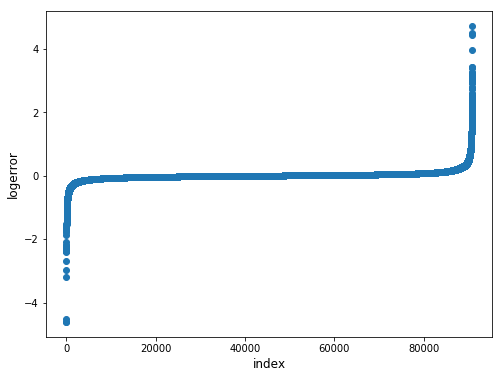

In [5]:
plt.figure(figsize=(8, 6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

This looks nice with some outliers at both the ends.! 

Let us remove the outliers and then do a histogram plot on the same.

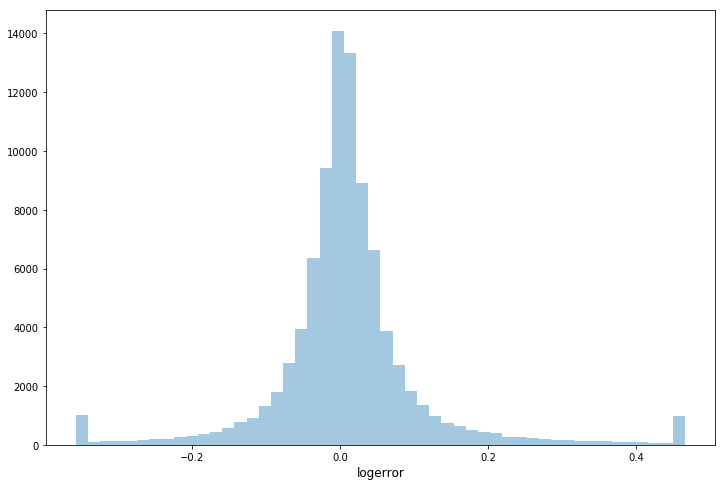

In [6]:
ulimit = np.percentile(train_df.logerror.values, 99)
llimit = np.percentile(train_df.logerror.values, 1)
train_df['logerror'].loc[train_df['logerror'] > ulimit] = ulimit
train_df['logerror'].loc[train_df['logerror'] < llimit] = llimit

plt.figure(figsize=(12, 8))
sns.distplot(train_df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

Wow. nice normal distribution on the log error.

**Transaction Date:**

Now let us explore the date field. Let us first check the number of transactions in each month. 

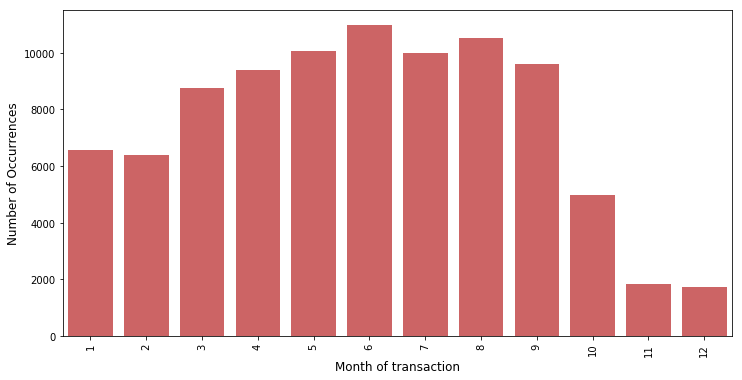

In [7]:
train_df['transaction_month'] = train_df['transactiondate'].dt.month

cnt_srs = train_df['transaction_month'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

As we could see from the data page as well
*The train data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016.*

So we have shorter bars in the last three months. 

**Parcel Id:**

In [8]:
(train_df['parcelid'].value_counts().reset_index())['parcelid'].value_counts()

1    90554
2      127
3        1
Name: parcelid, dtype: int64

So most of the parcel ids are appearing only once in the dataset.

**Properties 2016:**

Now let us explore the properties_2016 file. 

In [9]:
prop_df = pd.read_csv(datadir+"/properties_2016.csv")
prop_df.shape

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2985217, 58)

In [10]:
prop_df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34144442.0,-118654084.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,33989359.0,-118394633.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34148863.0,-118437206.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1947.0,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


There are so many NaN values in the dataset. So let us first do some exploration on that one. 

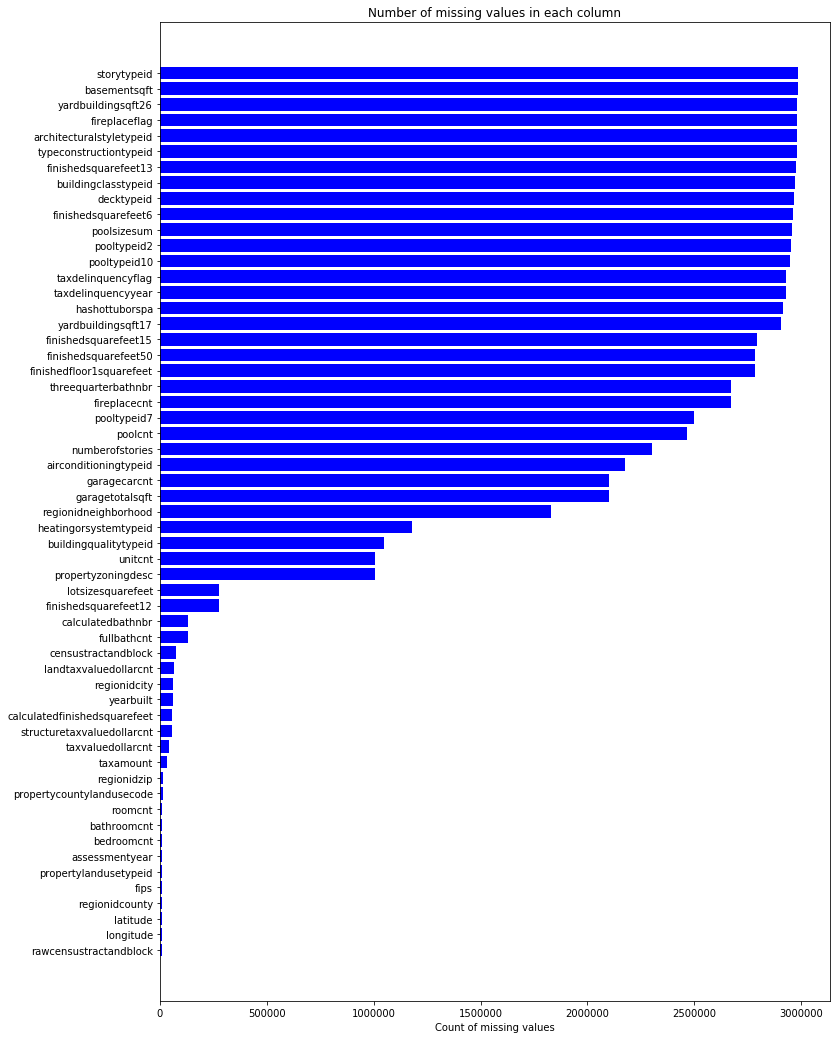

In [11]:
missing_df = prop_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count'] > 0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12, 18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

Let us explore the latitude and longitude variable to begin with.

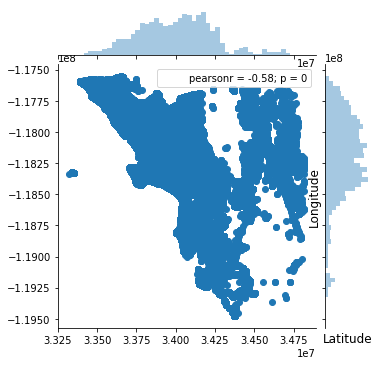

In [12]:
plt.figure(figsize=(12, 12))
sns.jointplot(x=prop_df.latitude.values, y=prop_df.longitude.values, size=5)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)

From the data page, *we are provided with a full list of real estate properties in three counties (Los Angeles, Orange and Ventura, California) data in 2016.*

We have about 90,811 rows in train but we have about 2,985,217 rows in properties file. So let us merge the two files and then carry out our analysis. 

In [13]:
train_df = pd.merge(train_df, prop_df, on='parcelid', how='left')
train_df.head()

,parcelid,logerror,transactiondate,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1,1.0,NaN,NaN,2.0,3.0,NaN,4.0,2.0,NaN,NaN,1684.0,1684.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,34280990.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,LARS,6.037107e+07,12447.0,3101.0,31817.0,96370.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,1,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,2263.0,2263.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,468.0,NaN,NaN,33668120.0,-117677556.0,3643.0,NaN,NaN,NaN,NaN,NaN,1,261.0,NaN,6.059052e+07,32380.0,1286.0,NaN,96962.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1,1.0,NaN,NaN,3.0,2.0,NaN,4.0,3.0,NaN,NaN,2217.0,2217.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,PSR6,6.037464e+07,47019.0,3101.0,275411.0,96293.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1,1.0,NaN,NaN,2.0,2.0,NaN,4.0,2.0,NaN,NaN,839.0,839.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,010C,266.0,LAR3,6.037296e+07,12447.0,3101.0,54300.0,96222.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,1,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,NaN,NaN,2283.0,2283.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,598.0,NaN,NaN,33485643.0,-117700234.0,6000.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059042e+07,17686.0,1286.0,NaN,96961.0,8.0,NaN,1.0,NaN,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


Now let us check the dtypes of different types of variable.

In [14]:
pd.options.display.max_rows = 65

dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,2
1,float64,53
2,datetime64[ns],1
3,object,5


Now let us check the number of Nulls in this new merged dataset.

In [15]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / train_df.shape[0]
missing_df.loc[missing_df['missing_ratio'] >= 0.90].sort_values(
    by=['missing_ratio'], ascending=False)

,column_name,missing_count,missing_ratio
9,buildingclasstypeid,90795,0.999824
16,finishedsquarefeet13,90778,0.999637
6,basementsqft,90768,0.999526
44,storytypeid,90768,0.999526
49,yardbuildingsqft26,90716,0.998954
52,fireplaceflag,90589,0.997555
5,architecturalstyletypeid,90550,0.997126
46,typeconstructiontypeid,90512,0.996707
19,finishedsquarefeet6,90390,0.995364
12,decktypeid,90153,0.992754


# Linear Models

Since there are so many variables, let us first take the 'float' variables alone and then get the correlation with the target variable to see how they are related.

In [33]:
# Let us just impute the missing values with mean values to compute correlation coefficients #
mean_values = train_df.mean(axis=0)
train_df_new = train_df.fillna(mean_values)

# Now let us look at the correlation coefficient of each of these variables #
x_cols = [
    col for col in train_df_new.columns if col not in ['logerror']
    if train_df_new[col].dtype == 'float64'
]
labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(
        np.corrcoef(train_df_new[col].values,
                    train_df_new.logerror.values)[0, 1])
corr_df = pd.DataFrame({'col_labels': labels, 'corr_values': values})
corr_df = corr_df.sort_values(by='corr_values')

/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


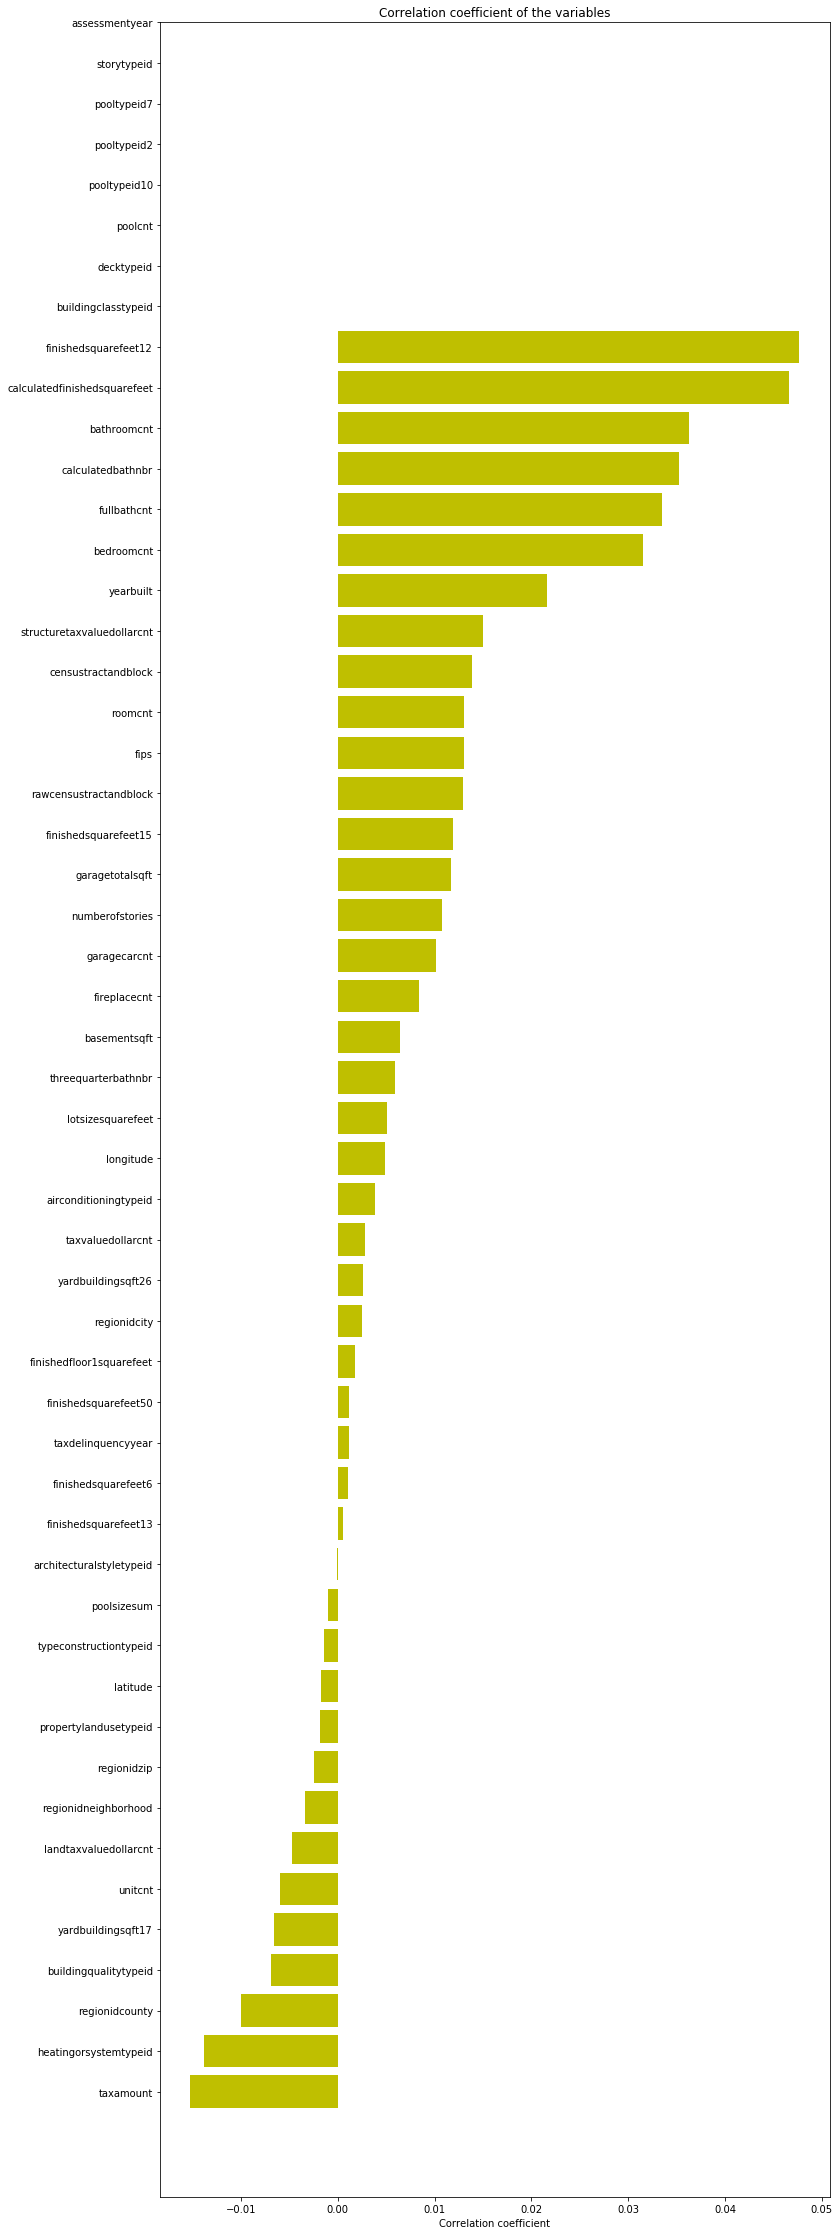

In [34]:
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12, 40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show()

The correlation of the target variable with the given set of variables are low overall. 

There are few variables at the top of this graph without any correlation values. I guess they have only one unique value and hence no correlation value. Let us confirm the same.

In [46]:
corr_nan_cols = corr_df[(corr_df.corr_values.isna())].col_labels.tolist()
for col in corr_nan_cols:
    print(col, len(train_df_new[col].unique()))

buildingclasstypeid 1
decktypeid 1
poolcnt 1
pooltypeid10 1
pooltypeid2 1
pooltypeid7 1
storytypeid 1
assessmentyear 1


Let us take the variables with high correlation values and then do some analysis on them. 

In [48]:
corr_df_sel = corr_df.loc[(corr_df['corr_values'] > 0.02)
                          | (corr_df['corr_values'] < -0.01)]
corr_df_sel

,col_labels,corr_values
49,taxamount,-0.015226
21,heatingorsystemtypeid,-0.013859
43,yearbuilt,0.021631
4,bedroomcnt,0.031530
18,fullbathcnt,0.033543
7,calculatedbathnbr,0.035301
3,bathroomcnt,0.036250
10,calculatedfinishedsquarefeet,0.046600
11,finishedsquarefeet12,0.047669


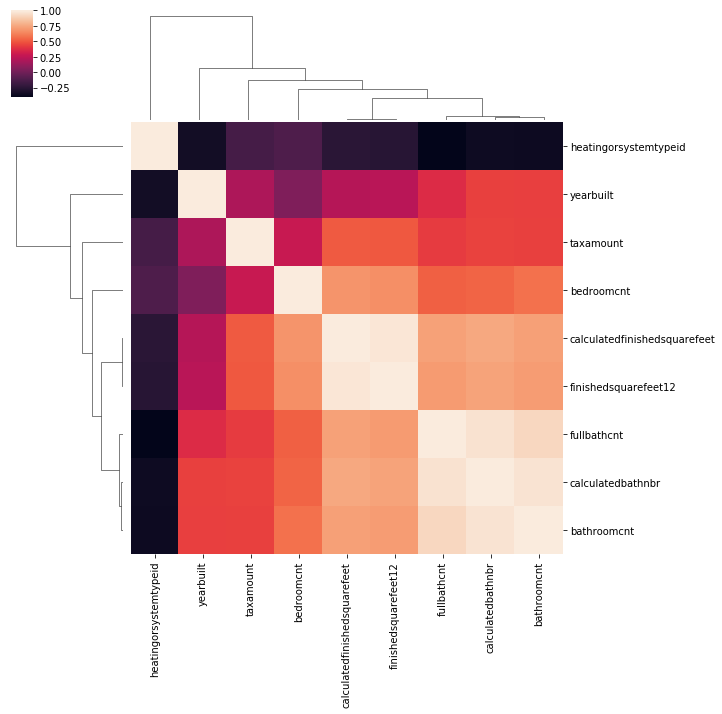

In [54]:
cols_to_use = corr_df_sel.col_labels.tolist()
temp_df = train_df[cols_to_use]
corrmat = temp_df.corr(method='spearman')

# Draw the heatmap using seaborn
sns.clustermap(
    corrmat, vmax=1., square=True)

The important variables themselves are very highly correlated.! Let us now look at each of them.

**Finished SquareFeet 12:**

Let us seee how the finished square feet 12 varies with the log error.

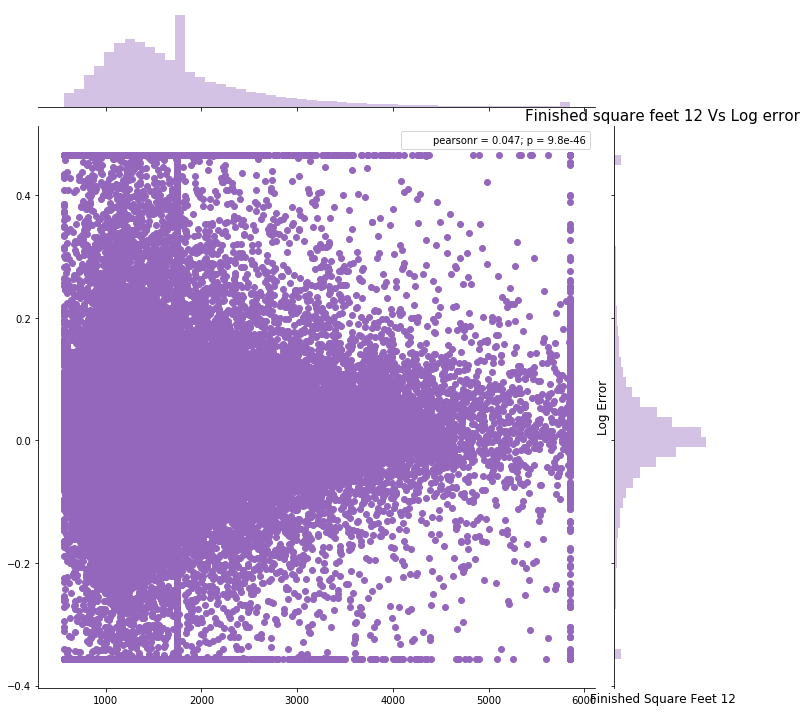

In [55]:
col = "finishedsquarefeet12"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].loc[train_df[col] > ulimit] = ulimit
train_df[col].loc[train_df[col] < llimit] = llimit

plt.figure(figsize=(12, 12))
sns.jointplot(
    x=train_df.finishedsquarefeet12.values,
    y=train_df.logerror.values,
    size=10,
    color=color[4])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Finished Square Feet 12', fontsize=12)
plt.title("Finished square feet 12 Vs Log error", fontsize=15)
plt.show()

Seems the range of logerror narrows down with increase in finished square feet 12 variable. Probably larger houses are easy to predict?

**Calculated finished square feet:**

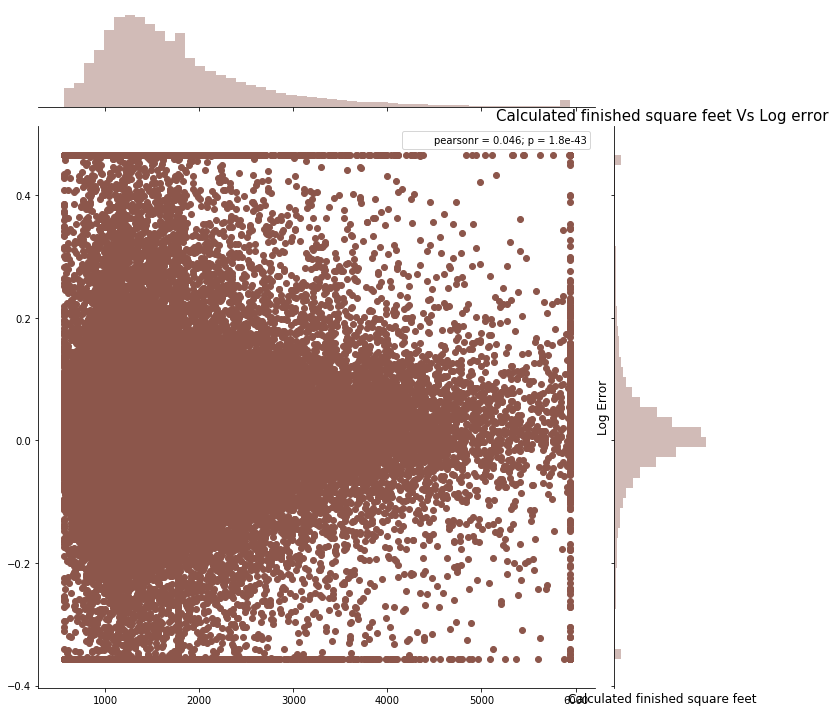

In [56]:
col = "calculatedfinishedsquarefeet"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].loc[train_df[col] > ulimit] = ulimit
train_df[col].loc[train_df[col] < llimit] = llimit

plt.figure(figsize=(12, 12))
sns.jointplot(
    x=train_df.calculatedfinishedsquarefeet.values,
    y=train_df.logerror.values,
    size=10,
    color=color[5])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Calculated finished square feet', fontsize=12)
plt.title("Calculated finished square feet Vs Log error", fontsize=15)
plt.show()

Here as well the distribution is very similar to the previous one. No wonder the correlation between the two variables are also high.

**Bathroom Count:**

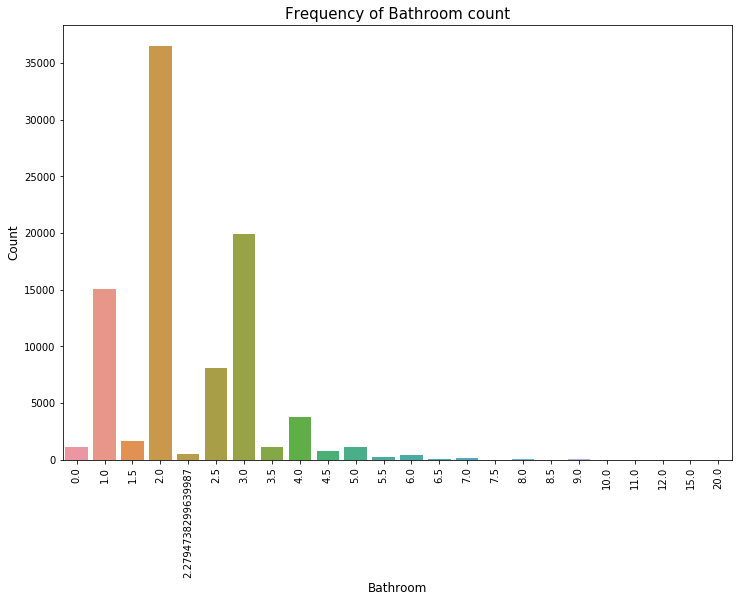

In [57]:
plt.figure(figsize=(12, 8))
sns.countplot(x="bathroomcnt", data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Bathroom', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bathroom count", fontsize=15)
plt.show()

There is an interesting 2.279 value in the bathroom count which is the mean value with which we replaced the Null values.

Now let us check how the log error changes based on this.

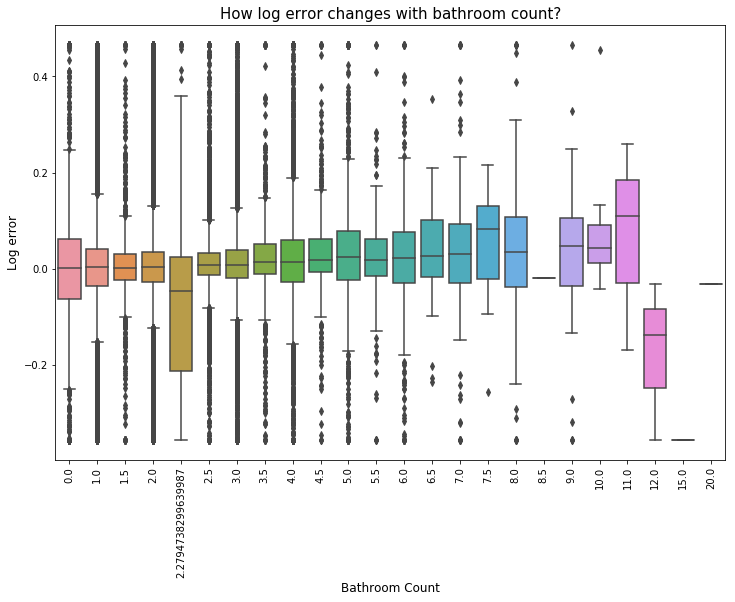

In [58]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="bathroomcnt", y="logerror", data=train_df)
plt.ylabel('Log error', fontsize=12)
plt.xlabel('Bathroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("How log error changes with bathroom count?", fontsize=15)
plt.show()

**Bedroom count:**

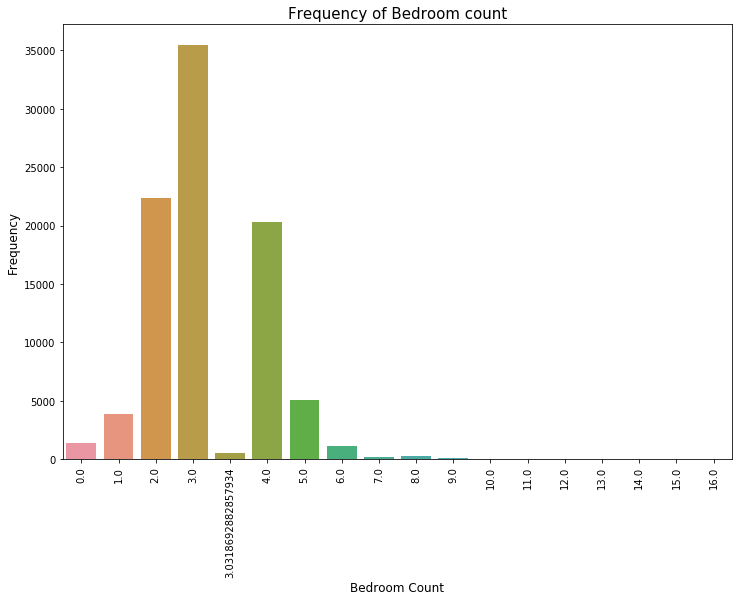

In [59]:
plt.figure(figsize=(12, 8))
sns.countplot(x="bedroomcnt", data=train_df)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Bedroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bedroom count", fontsize=15)
plt.show()

3.03 is the mean value with which we replaced the Null values.

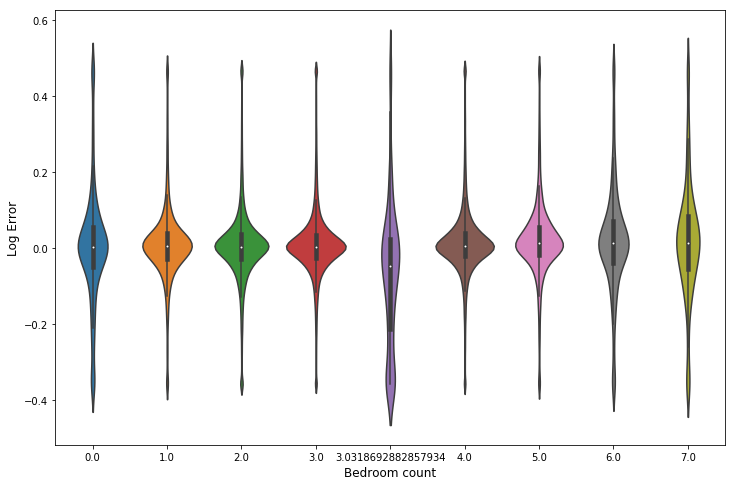

In [60]:
train_df['bedroomcnt'].loc[train_df['bedroomcnt'] > 7] = 7
plt.figure(figsize=(12, 8))
sns.violinplot(x='bedroomcnt', y='logerror', data=train_df)
plt.xlabel('Bedroom count', fontsize=12)
plt.ylabel('Log Error', fontsize=12)
plt.show()

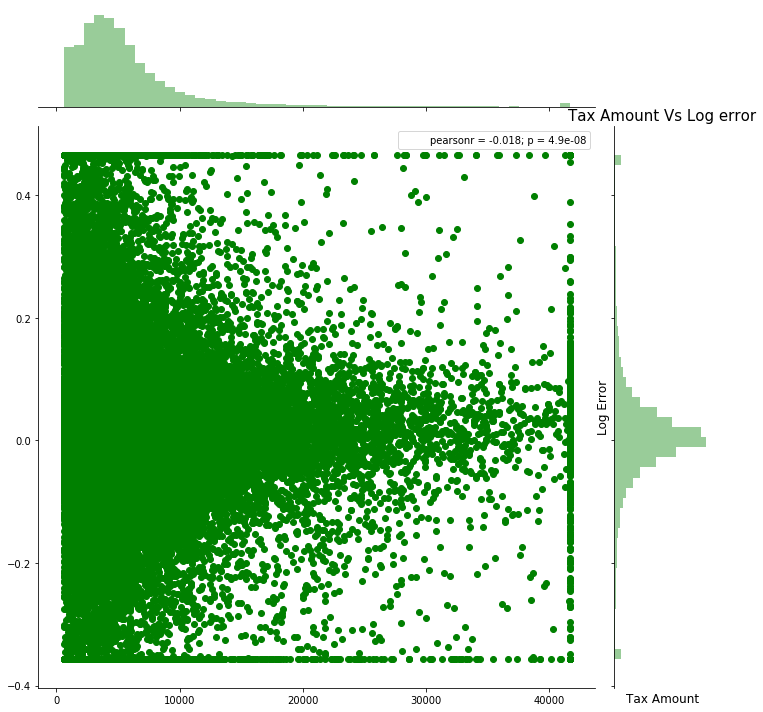

In [61]:
col = "taxamount"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].loc[train_df[col] > ulimit] = ulimit
train_df[col].loc[train_df[col] < llimit] = llimit

plt.figure(figsize=(12, 12))
sns.jointplot(
    x=train_df['taxamount'].values,
    y=train_df['logerror'].values,
    size=10,
    color='g')
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Tax Amount', fontsize=12)
plt.title("Tax Amount Vs Log error", fontsize=15)
plt.show()

**YearBuilt:**

Let us explore how the error varies with the yearbuilt variable.

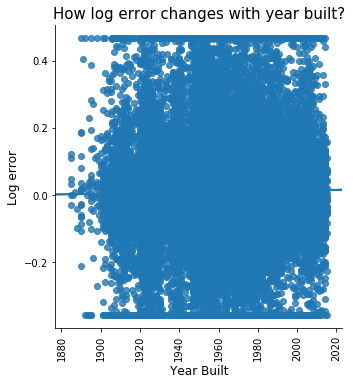

In [64]:
plt.figure(figsize=(12, 8))
sns.lmplot(x="yearbuilt", y="logerror", data=train_df)
plt.ylabel('Log error', fontsize=12)
plt.xlabel('Year Built', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("How log error changes with year built?", fontsize=15)
plt.show()

There is a minor incremental trend seen with respect to built year.

Now let us see how the logerror varies with respect to latitude and longitude.

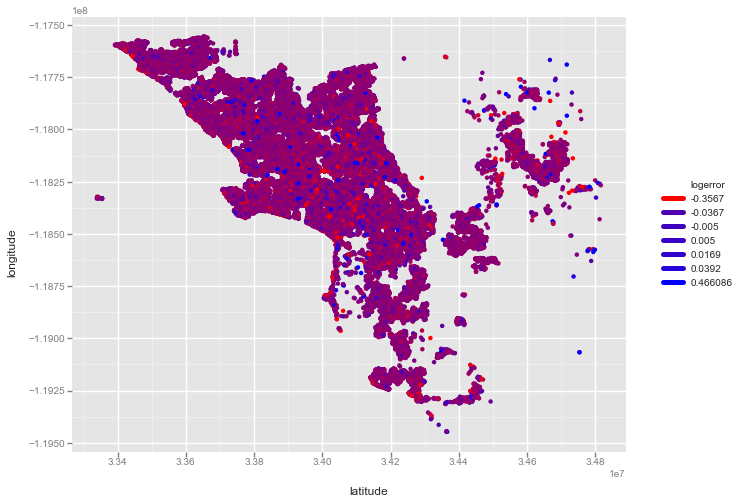

<ggplot: (-9223372036561428322)>

In [45]:
ggplot(aes(x='latitude', y='longitude', color='logerror'), data=train_df) + \
    geom_point() + \
    scale_color_gradient(low = 'red', high = 'blue')

There are no visible pockets as such with respect to latitude or longitude atleast with the naked eye.

Let us take the variables with highest positive correlation and highest negative correlation to see if we can see some visible patterns.

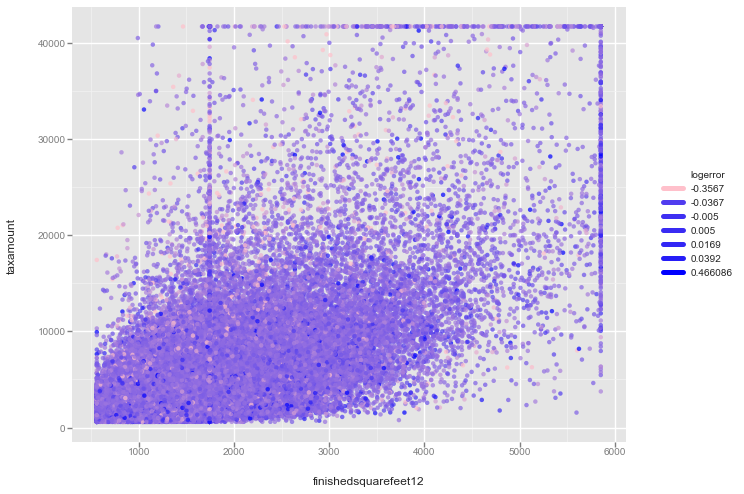

<ggplot: (-9223372036561401326)>

In [46]:
ggplot(aes(x='finishedsquarefeet12', y='taxamount', color='logerror'), data=train_df) + \
    geom_point(alpha=0.7) + \
    scale_color_gradient(low = 'pink', high = 'blue')

There are no visible patterns here as well. So this is going to be a hard competition to predict I guess.

# Non-linear Models

We had an understanding of important variables from the univariate analysis. But this is on a stand alone basis and also we have linearity assumption. Now let us build a non-linear model to get the important variables by building Extra Trees model.

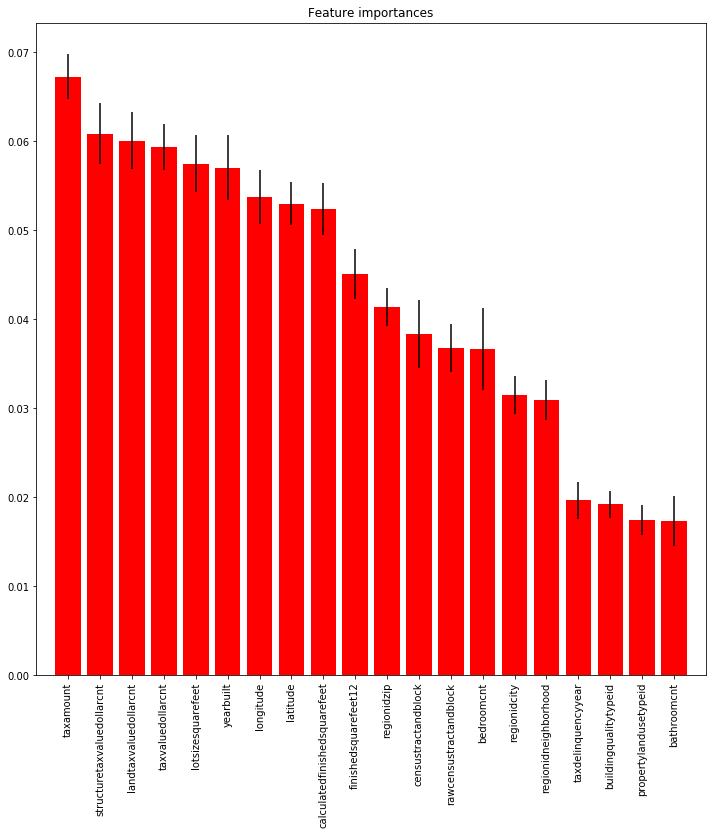

In [65]:
train_y = train_df['logerror'].values
cat_cols = [
    "hashottuborspa", "propertycountylandusecode", "propertyzoningdesc",
    "fireplaceflag", "taxdelinquencyflag"
]
train_df = train_df.drop(
    ['parcelid', 'logerror', 'transactiondate', 'transaction_month'] +
    cat_cols,
    axis=1)
feat_names = train_df.columns.values

from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(
    n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(train_df, train_y)

## plot the importances ##
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12, 12))
plt.title("Feature importances")
plt.bar(
    range(len(indices)),
    importances[indices],
    color="r",
    yerr=std[indices],
    align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

Seems "tax amount" is the most importanct variable followed by "structure tax value dollar count" and "land tax value dollor count"



In [71]:
import xgboost as xgb
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed': 0
}
dtrain = xgb.DMatrix(train_df, train_y, feature_names=train_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

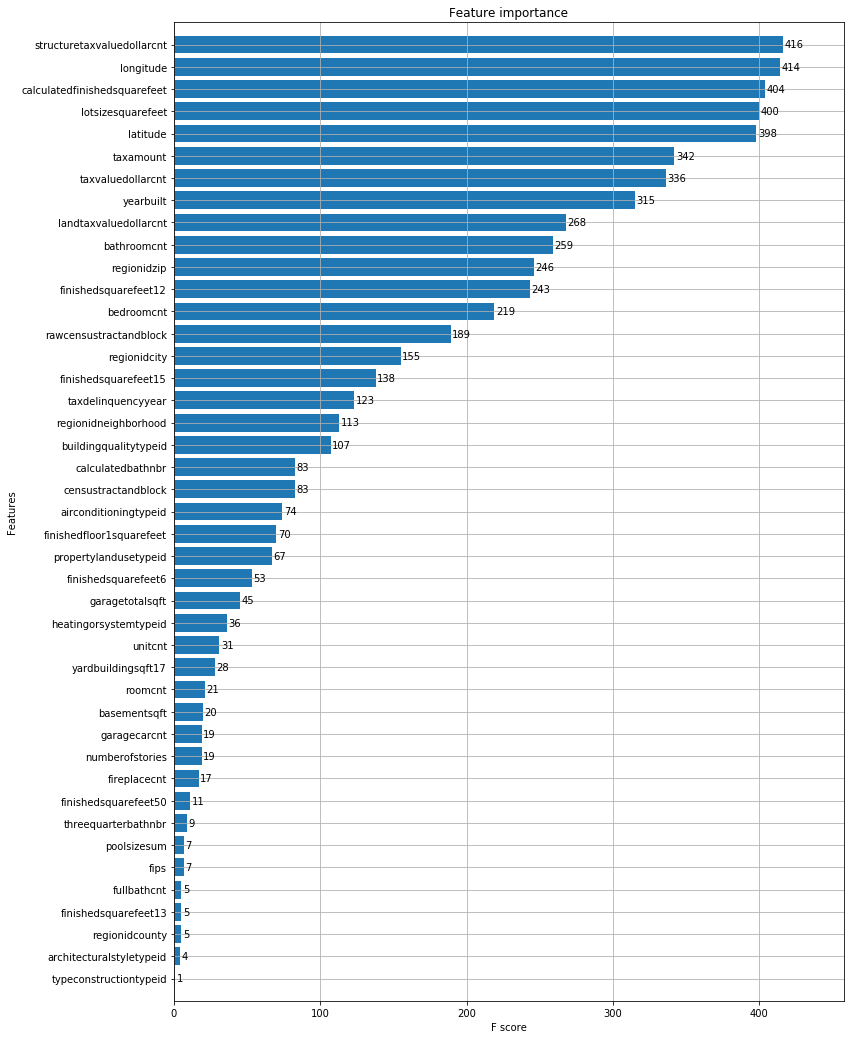

In [72]:
# plot the important features #
fig, ax = plt.subplots(figsize=(12, 18))
xgb.plot_importance(model, height=0.8, ax=ax)
plt.show()

Using xgboost, the important variables are 'structured tax value dollar count' followed by 'latitude' and 'calculated finished square feet' 

# Scratch

In [2]:
import h2o
from h2o.automl import H2OAutoML

In [ ]:
h2o.init()

# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("https://s3.amazonaws.com/erin-data/higgs/higgs_train_10k.csv")
test = h2o.import_file("https://s3.amazonaws.com/erin-data/higgs/higgs_test_5k.csv")

# Identify predictors and response
x = train.columns
y = "response"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 30 seconds
aml = H2OAutoML(max_runtime_secs = 30)
aml.train(x = x, y = y,
          training_frame = train,
          leaderboard_frame = test)

# View the AutoML Leaderboard
lb = aml.leaderboard

In [4]:
lb

# model_id                                            auc       logloss
# --------------------------------------------------  --------  ---------
#           StackedEnsemble_model_1494643945817_1709  0.780384  0.561501
# GBM_grid__95ebce3d26cd9d3997a3149454984550_model_0  0.764791  0.664823
# GBM_grid__95ebce3d26cd9d3997a3149454984550_model_2  0.758109  0.593887
#                          DRF_model_1494643945817_3  0.736786  0.614430
#                        XRT_model_1494643945817_461  0.735946  0.602142
# GBM_grid__95ebce3d26cd9d3997a3149454984550_model_3  0.729492  0.667036
# GBM_grid__95ebce3d26cd9d3997a3149454984550_model_1  0.727456  0.675624
# GLM_grid__95ebce3d26cd9d3997a3149454984550_model_1  0.685216  0.635137
# GLM_grid__95ebce3d26cd9d3997a3149454984550_model_0  0.685216  0.635137


# The leader model is stored here
aml.leader


# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly

preds = aml.predict(test)

# or:
preds = aml.leader.predict(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
